In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from preprocessing import *
from pathlib import Path

from PIL import Image
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

In [3]:
DATADIR = "/home/virk/devs/Projects/MolecularTranslationKaggleCompetition/data"
!ls {DATADIR}

sample_submission.csv  test  train  train_labels.csv


In [4]:
traindf = pd.read_csv(f"{DATADIR}/train_labels.csv")
print(f"df size = {traindf.shape}")
traindf.sample(5)

df size = (2424186, 2)


,image_id,InChI
637443,4347c81846e0,InChI=1S/C23H21N7O/c31-23(20-8-6-19(7-9-20)18-...
1001118,69b302341421,"InChI=1S/C21H23N7O3/c1-12-13(2)21(12,20(30)27-..."
794983,53e04f9c45ac,InChI=1S/C12H11N3O2/c1-15(10-3-2-4-13-7-10)12(...
2357720,f8f2de139b0c,InChI=1S/C19H20ClN5O/c1-3-13(2)14-8-10-15(11-9...
119595,0c99c01b568a,InChI=1S/C24H30N4O2S/c1-4-22(29)28-15-13-27(14...


In [5]:
train_imgpaths = Path(f"{DATADIR}/train").rglob('*.*')

In [6]:
imgpath = next(train_imgpaths)
traindf[traindf.image_id == imgpath.stem]["InChI"].values[0]

'InChI=1S/C22H22ClNO3/c23-19-9-5-4-8-16(19)17-14-18(17)20(25)24-12-10-22(11-13-24,21(26)27)15-6-2-1-3-7-15/h1-9,17-18H,10-14H2,(H,26,27)'

(263, 477)


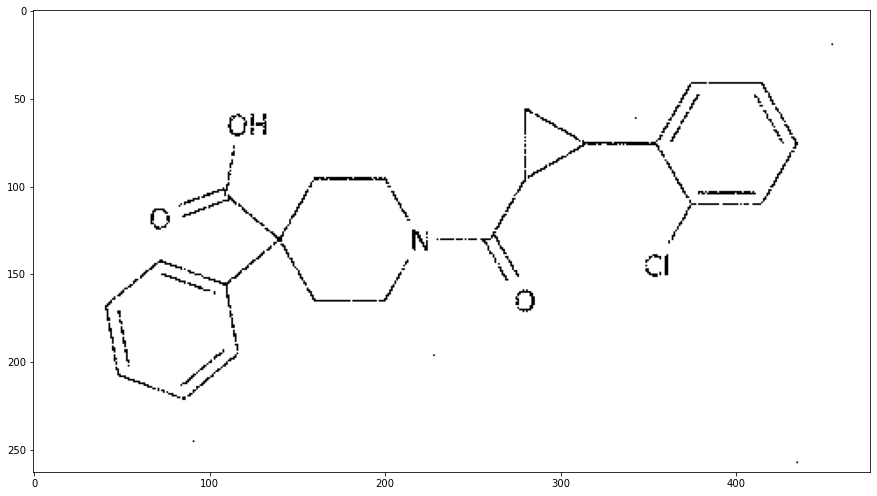

In [7]:
img = plt.imread(imgpath)
print(img.shape)
plt.figure(figsize=(15,10))
plt.imshow(img, cmap='gray')

# Feature matching

In [8]:
INP_SIZE = (256, 256)

def inchi_to_img(inchi_string):
    chem_obj = Chem.MolFromInchi(inchi_string)
    chem_obj = Draw.MolToImage(chem_obj)
    chem_obj = minmaxscaler(np.array(chem_obj)).prod(axis=-1)
    chem_obj = (1 - chem_obj)*255
    chem_obj[chem_obj >= 100] = 255
    chem_obj[chem_obj < 100] = 0
    chem_obj = zero_trim_ndarray(chem_obj)
    chem_obj = resizeAndPad(chem_obj, INP_SIZE, 0).astype(np.uint8)
    return chem_obj

def path_to_img(imgpath, min_contour_area=5):
    img = Image.open(imgpath)
    img = ImageOps.invert(img)
    img = img.filter(ImageFilter.MaxFilter(3))
    img = zero_trim_ndarray(np.array(img))
    img = resizeAndPad(img, INP_SIZE, 0).astype(np.uint8)
    # find contours in the thresholded image
    cnts = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    # print("[INFO] {} unique contours found".format(len(cnts)))
    # loop over the contours
    img = np.stack((img, img, img), axis=-1)
    for (i, c) in enumerate(cnts):
        if cv2.contourArea(c) < min_contour_area:
            cv2.fillPoly(img, [c], color=(255, 0, 0))
    img = img[...,-1]
    return img

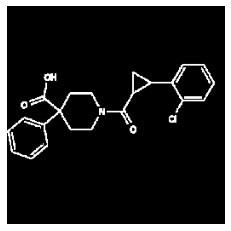

In [9]:
inp_img = path_to_img(imgpath)
plt.imshow(inp_img, cmap='gray')
plt.axis('off');

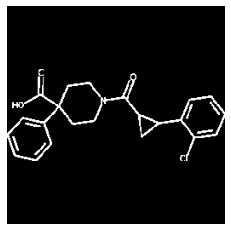

In [10]:
inchi_string = traindf[traindf.image_id == imgpath.stem]["InChI"].values[0]
inchi_img = inchi_to_img(inchi_string)
plt.imshow(inchi_img, cmap='gray')
plt.axis('off');

In [11]:
sift = cv2.SIFT_create()
keypoints_1, descriptors_1 = sift.detectAndCompute(inp_img,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(inchi_img,None)
#feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
matches = bf.match(descriptors_1, descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

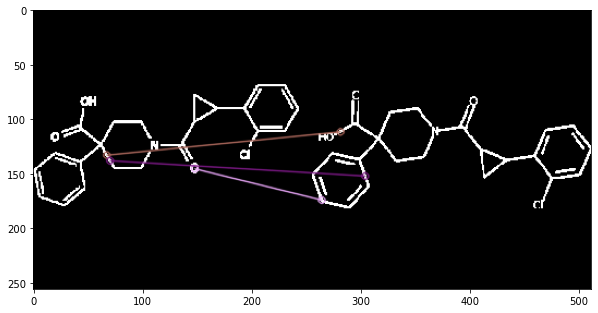

In [12]:
img3 = cv2.drawMatches(inp_img, keypoints_1, inchi_img, keypoints_2, matches[:3], inchi_img, flags=2)
plt.figure(figsize=(10,10))
plt.imshow(img3)

In [13]:
sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(inp_img, None)
kp2, des2 = sift.detectAndCompute(inchi_img, None)

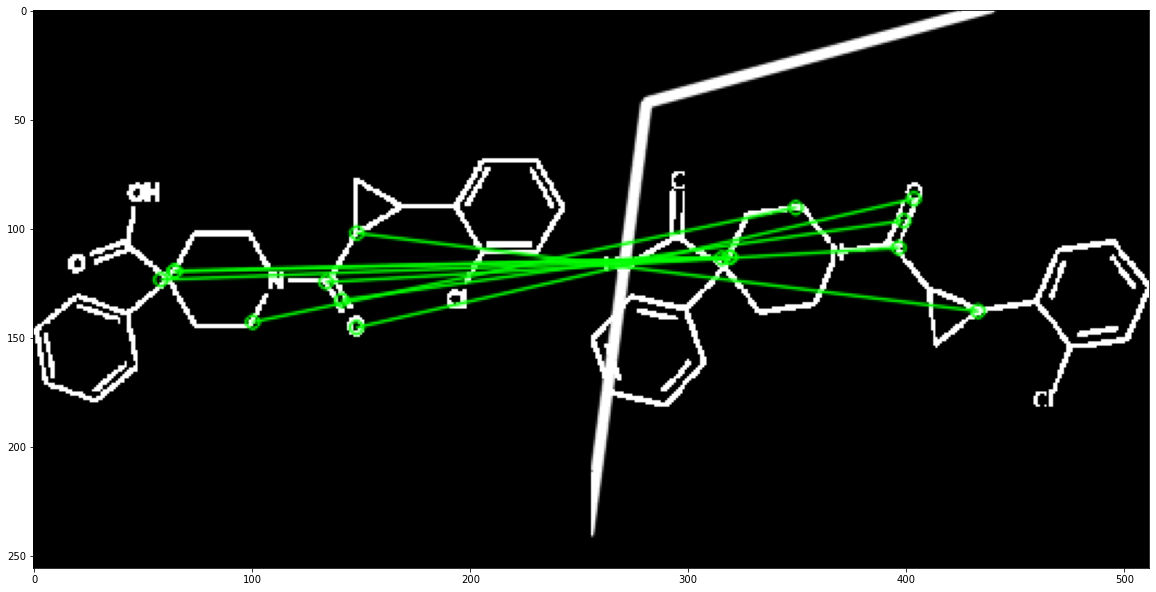

In [14]:
FLANN_INDEX_KDTREE = 0
MIN_MATCH_COUNT = 10
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
        
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    h,w = inp_img.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)

    inchi_img = cv2.polylines(inchi_img,[np.int32(dst)],True,255,3, cv2.LINE_AA)

else:
    print (f"Not enough matches are found - {len(good)} {MIN_MATCH_COUNT}")
    matchesMask = None
    
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(inp_img,kp1,inchi_img,kp2,good,None,**draw_params)

plt.figure(figsize=(20,20))
plt.imshow(img3, 'gray')

In [15]:
from sklearn.metrics.pairwise import cosine_similarity
from skimage.metrics import structural_similarity as ssim

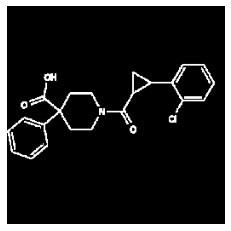

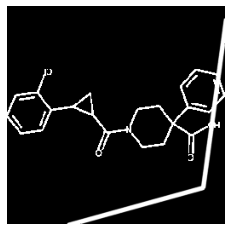

In [16]:
plt.imshow(inp_img, cmap='gray')
plt.axis('off')
plt.show()
# plt.imshow(inchi_img, cmap='gray')
# plt.axis('off')
# plt.show()
# plt.imshow(np.rot90(inchi_img), cmap='gray')
# plt.axis('off')
# plt.show()
plt.imshow(np.flip(inchi_img), cmap='gray')
plt.axis('off')
plt.show()

In [17]:
print(ssim(inp_img, inchi_img).mean())
print(ssim(inp_img, np.rot90(inchi_img)).mean())
print(ssim(inp_img, np.flip(inchi_img)).mean())

0.7443448084018418
0.6999359760983864
0.7229572545176128


# InChI to Molecule

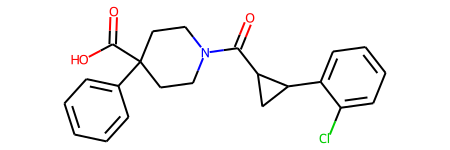

In [18]:
# imgpath = next(train_imgpaths)
inchi_string = traindf[traindf.image_id == imgpath.stem]["InChI"].values[0]
chem_obj = Chem.MolFromInchi(inchi_string)
chem_obj

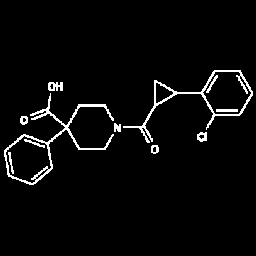

In [22]:
preprocess_image(imgpath)

In [23]:
oimg = np.array(Draw.MolToImage(chem_obj))

In [24]:
# Draw.MolToImage(chem_obj).save("test.png")

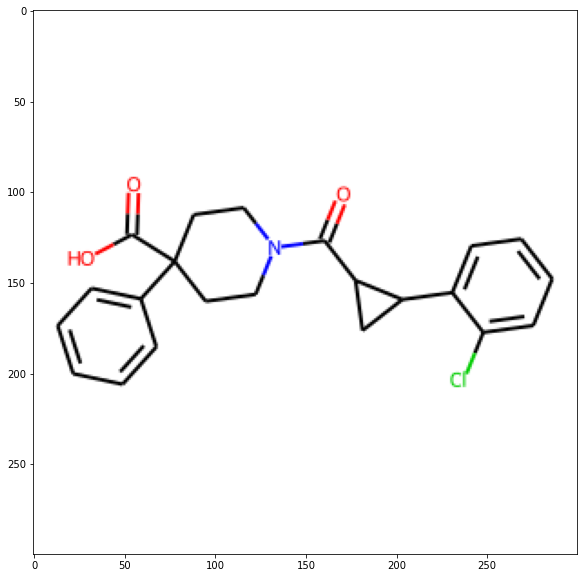

In [25]:
plt.figure(figsize=(15,10))
plt.imshow(oimg, cmap='gray')

In [26]:
def mol_with_atom_index(mol):
    """https://www.kaggle.com/sapr3s/inchi-samples"""
    for i, atom in enumerate(mol.GetAtoms()):
        atom.SetAtomMapNum(atom.GetIdx()+1)
    return mol

def mol_with_hybridization(mol):
    for i, atom in enumerate(mol.GetAtoms()):
        count_hydrogens = atom.GetTotalNumHs()
        if count_hydrogens==0:
            lbl = '%s'%(atom.GetSymbol())
#         elif count_hydrogens==1:
#             lbl = '%sH'%(atom.GetSymbol())
        else:
            lbl = '%sH%s'%(atom.GetSymbol(),count_hydrogens)
        atom.SetProp('atomLabel',lbl)
    return mol

def show_img(inchi, d=True):
    mol = Chem.MolFromInchi(inchi)
    display(mol)
    if d:
        display(mol_with_atom_index(mol))
        display(mol_with_hybridization(mol))

InChI=1S/C10H8F6O/c11-9(12,13)8(17,10(14,15)16)7-4-5-1-2-6(7)3-5/h1-2,4-6,17H,3H2


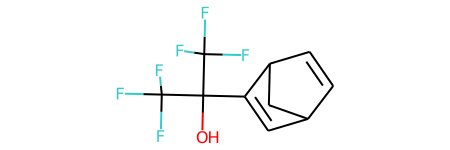

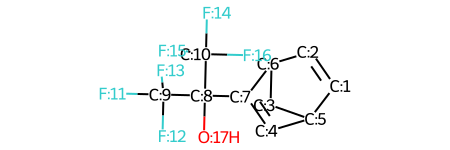

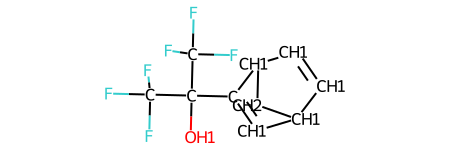

In [27]:
imgpath = next(train_imgpaths)
inchi_string = traindf[traindf.image_id == imgpath.stem]["InChI"].values[0]
print(inchi_string)
show_img(inchi_string)

In [29]:
# img = plt.imread(imgpath)
# plt.figure(figsize=(15,10))
# oimg = preprocess_image(img)
# print(oimg.shape)
# plt.imshow(oimg, cmap='gray')

## Line detection

In [30]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from preprocessing import preprocess_image
from scipy import ndimage, misc

In [31]:
img = plt.imread("test.png")
img.shape

(300, 300, 3)

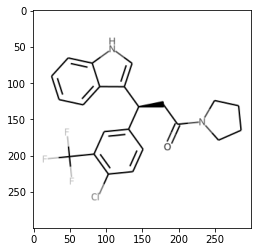

In [32]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY), cmap='gray')

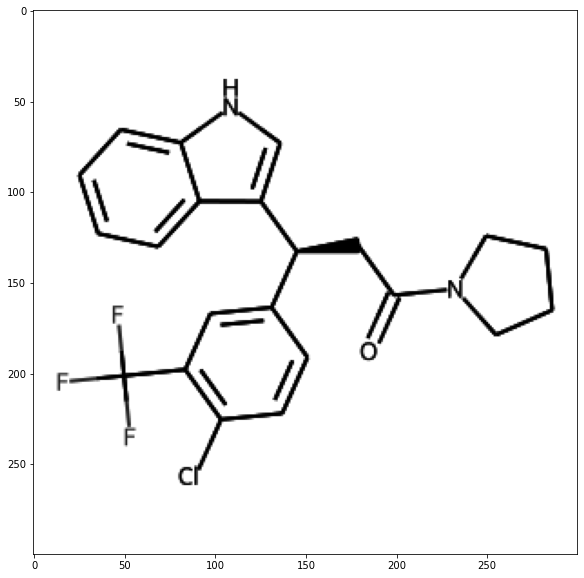

In [34]:
plt.figure(figsize=(10, 10))
plt.imshow(img.prod(axis=-1), cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


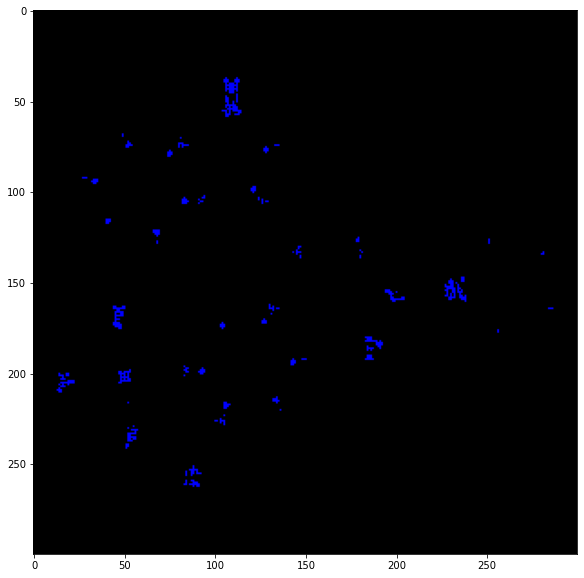

In [40]:
img = plt.imread("test.png")
gray = img.prod(axis=-1)
gray = (gray*255).astype(np.uint8)
gray = cv2.GaussianBlur(gray,(3,3),0)

gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)

#result is dilated for marking the corners, not important
# dst = cv2.dilate(dst,None)
img *= 0.
# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()]=[0,0,255]

plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


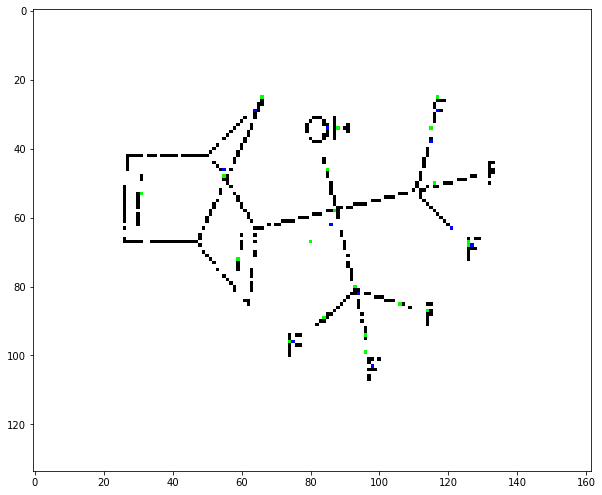

In [43]:
img = plt.imread(imgpath)
img = np.stack((img, img, img), axis=-1)
gray = img.prod(axis=-1)
gray = (gray*255).astype(np.uint8)
gray = cv2.GaussianBlur(gray,(3,3),0)

# find Harris corners
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)
dst = cv2.dilate(dst,None)
ret, dst = cv2.threshold(dst,0.01*dst.max(),255,0)
dst = np.uint8(dst)

# find centroids
ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)

# define the criteria to stop and refine the corners
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)

# Now draw them
# img *= 0.
res = np.hstack((centroids,corners))
res = np.int0(res)
img[res[:,1],res[:,0]]=[0,0,255]
img[res[:,3],res[:,2]] = [0,255,0]

plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='gray')